# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import multiprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
plt.style.use('ggplot')
num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 12


# Data preprocessing

### Reading to a DataFrame, Drop irrelevant colums and Split to train and valid sets

In [2]:
# Read data and choose target variable
X = pd.read_csv('train_data.csv')
y = X['PRICE']

In [3]:
# Dropping irrelevant features and target variable
X.drop(['ADDRESS', 'SUBURB', 'NEAREST_STN', 'POSTCODE', 'NEAREST_SCH', 'PRICE'], axis=1, inplace=True)

In [4]:
# Splitting data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [5]:
for col in X_train.columns:
    print(col, X_train[col].dtype)

BEDROOMS int64
BATHROOMS int64
GARAGE float64
LAND_AREA int64
FLOOR_AREA int64
BUILD_YEAR float64
CBD_DIST int64
NEAREST_STN_DIST int64
DATE_SOLD object
LATITUDE float64
LONGITUDE float64
NEAREST_SCH_DIST float64
NEAREST_SCH_RANK float64


In [6]:
X_train.head(3)

,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,DATE_SOLD,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,NEAREST_SCH_RANK
19011,4,2,1.0,1634,203,1960.0,11800,123,11-2015\r,-31.897840,115.965510,1.603855,52.0
2973,4,2,2.0,20446,196,NaN,39000,28200,08-2020\r,-31.641828,116.050497,16.303987,98.0
9641,4,2,2.0,900,224,1995.0,32300,2800,05-2018\r,-31.691510,115.708940,1.033592,NaN


### 'DATE_SOLD' column handling

Ideas on what to do with the date:
1) Extract only the years and use OrdinalEncoder.
2) Convert the dates to the number of seconds/minutes/hours/days since 1970-01-01. (consider some normalization but I believe that in ensamble methods such as XGBoost it is not required)

In [7]:
min(pd.to_datetime(X_train['DATE_SOLD'])) # It's later than 1970-01-01 so we're good

Timestamp('1988-04-01 00:00:00')

In [8]:
# Approach 2

# Convert to integers
X_train['DATE_SOLD'] = pd.to_datetime(X_train['DATE_SOLD']).astype(int) // 10**9 # // 10**9 because astype(int) returns nanoseconds from 1970-01-01
X_valid['DATE_SOLD'] = pd.to_datetime(X_valid['DATE_SOLD']).astype(int) // 10**9

# Perform normalization
# scaler = MinMaxScaler()
# scaled_date_train = scaler.fit_transform(X_train[['DATE_SOLD']])
# scaled_date_valid = scaler.transform(X_valid[['DATE_SOLD']])
# X_train['DATE_SOLD'] = scaled_date_train
# X_valid['DATE_SOLD'] = scaled_date_valid

In our dataframe there isn't any categorical variables left therefore we can go to the next step

### NaN values handling

In [9]:
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]
for col in cols_with_missing:
    print(col, X_train[col].isnull().sum())

GARAGE 1342
BUILD_YEAR 1721
NEAREST_SCH_RANK 6125


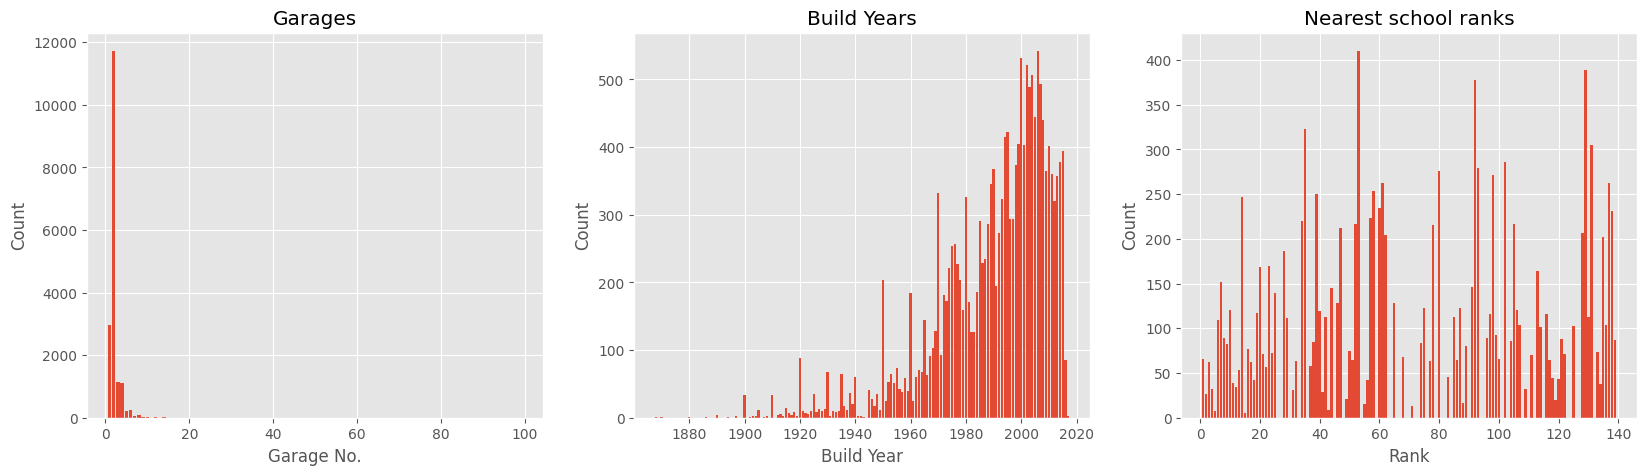

In [10]:
garages = X_train['GARAGE'].value_counts().sort_index()
garages.index = garages.index.astype('int')

build_yrs = X_train['BUILD_YEAR'].value_counts().sort_index()
build_yrs.index = build_yrs.index.astype('int')

sch_ranks = X_train['NEAREST_SCH_RANK'].value_counts().sort_index()
sch_ranks.indes = sch_ranks.index.astype('int')

fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].bar(garages.index, garages.values)
ax[0].set_xlabel('Garage No.')
ax[0].set_ylabel('Count')
ax[0].set_title('Garages')

ax[1].bar(build_yrs.index, build_yrs.values)
ax[1].set_xlabel('Build Year')
ax[1].set_ylabel('Count')
ax[1].set_title('Build Years')

ax[2].bar(sch_ranks.index, sch_ranks.values)
ax[2].set_xlabel('Rank')
ax[2].set_ylabel('Count')
ax[2].set_title('Nearest school ranks')

plt.show()

Potential approaches:
1) Drop rows with NaN values
2) Impute mean, median or most_frequent value from column

In [ ]:
# Approach 2:

# For build year: median
# For nearest school rank and garage: most_frequent

# create preprocessor that will be added to a pipeline

most_freq_cols = ['GARAGE', 'NEAREST_SCH_RANK']
median_cols = ['BUILD_YEAR']

most_freq_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

preprocessor = ColumnTransformer(
    transformers=[
        ('most_freq', most_freq_imputer, most_freq_cols),
        ('median', median_imputer, median_cols)
    ],
    remainder='passthrough')


### Exploratory Data Analysis

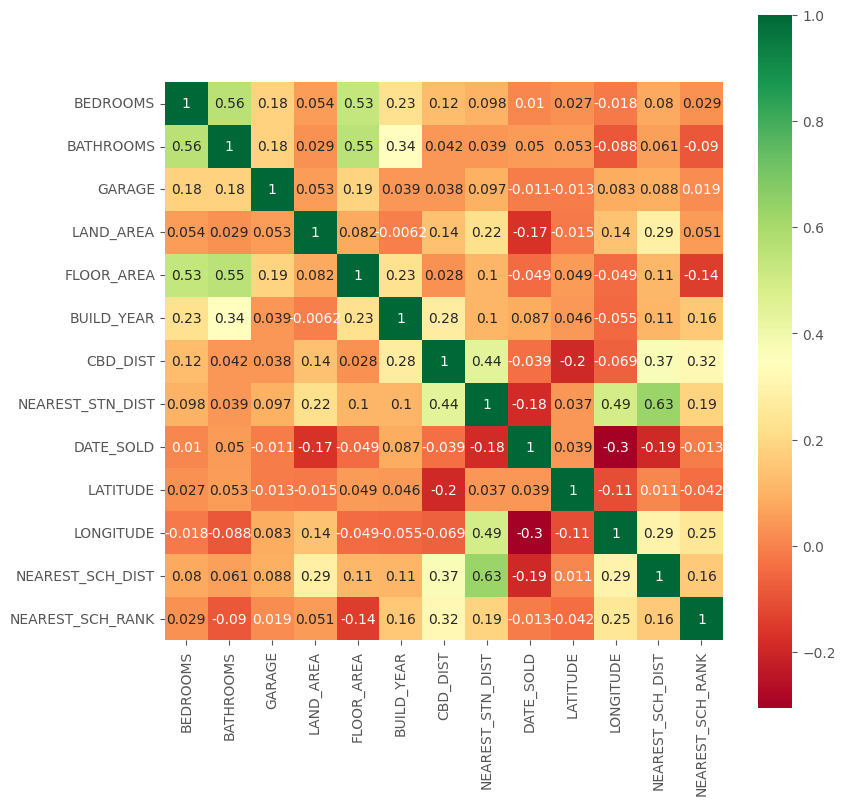

In [12]:
plt.figure(figsize=(9,9))
sns.heatmap(X_train.corr(), square=True, cmap='RdYlGn', annot=True)
plt.show()

In [ ]:
plt.bar(np.arange(len(y)), sorted(y))
plt.ticklabel_format(style='plain')
plt.xticks([])
plt.ylabel('Price [USD]')
plt.title('House prices')
plt.show()

# Building pipeline with regressor

In [21]:
params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    # 'n_estimators':100,
    # 'early_stopping_rounds': 5,
    'n_jobs': num_cores,
    # 'tree_method': 'gpu_hist',  # use GPU for training
    # 'gpu_id': 0,
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('regressor', xgb.XGBRegressor(**params))
])

#pipeline.set_params(regressor__eval_set=[(X_valid, y_valid)])
# X_train_transformed = preprocessor.fit_transform(X_train)
# X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns)
# X_valid.columns = np.arange(len(X_valid.columns))
# X_train.columns = np.arange(len(X_train.columns))
# X_valid_transformed = preprocessor.transform(X_valid)
# pipeline.named_steps['regressor'].fit(X_train, y_train, eval_set=[(X_valid_transformed, y_valid)])

pipeline.fit(X_train, y_train) #, regressor__eval_set = [(X_valid, y_valid)])

y_pred = pipeline.predict(X_valid)
mae = mean_absolute_error(y_pred, y_valid)
print(f'Baseline Mean Absolute Error: {mae}')

Baseline Mean Absolute Error: 87720.0185986452


#### Fine tuning

In [26]:
param_grid = {
    'regressor__n_estimators': [200, 300, 350],
    'regressor__learning_rate': [0.1, 0.01],
    'regressor__max_depth': [5, 7],
    'regressor__subsample': [0.7, 0.8, 0.9],
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_valid)
mae = mean_absolute_error(y_pred, y_valid)
print(f'Fine-tuned Mean Absolute Error: {mae}')
print(f'Tuned model params: {best_params}')

Fine-tuned Mean Absolute Error: 82388.21376688966
Tuned model params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 7, 'regressor__n_estimators': 350, 'regressor__subsample': 0.7}


In [ ]:
# 300, 0.1, 7, 0.8
# 82979

# 200, 0.1, 10, 0.7
# 83377

# 350, 0.1, 7, 0.7
# 82388

In [27]:
best_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('most_freq',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['GARAGE',
                                                   'NEAREST_SCH_RANK']),
                                                 ('median',
                                                  SimpleImputer(strategy='median'),
                                                  ['BUILD_YEAR'])])),
                ('scaler', StandardScaler()),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=350,
                              n_jobs=12, num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])